# Reuters Newswire Topic Classification Dataset with Transformers


In [85]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [86]:
# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(
    path="reuters.npz",
    num_words=10000,  # 10000 modest words
    skip_top=0,
    maxlen=200,  # max sequence length
    test_split=0.2,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3,
)

In [87]:
len(x_train)

7076

In [88]:
x_train[1]  # first newswire

[1,
 3267,
 699,
 3434,
 2295,
 56,
 2,
 7511,
 9,
 56,
 3906,
 1073,
 81,
 5,
 1198,
 57,
 366,
 737,
 132,
 20,
 4093,
 7,
 2,
 49,
 2295,
 2,
 1037,
 3267,
 699,
 3434,
 8,
 7,
 10,
 241,
 16,
 855,
 129,
 231,
 783,
 5,
 4,
 587,
 2295,
 2,
 2,
 775,
 7,
 48,
 34,
 191,
 44,
 35,
 1795,
 505,
 17,
 12]

In [89]:
y_train[1]

4

In [90]:
# Pad sequences to the same length
x_train = tf.keras.preprocessing.sequence.pad_sequences(
    x_train, maxlen=200, padding="post", truncating="post"
)
x_test = tf.keras.preprocessing.sequence.pad_sequences(
    x_test, maxlen=200, padding="post", truncating="post"
)

In [91]:
tf.keras.datasets.reuters.get_word_index(path="reuters_words_index.json")

{'mdbl': 10996,
 'fawc': 16260,
 'degussa': 12089,
 'woods': 8803,
 'hanging': 13796,
 'localized': 20672,
 'sation': 20673,
 'chanthaburi': 20675,
 'refunding': 10997,
 'hermann': 8804,
 'passsengers': 20676,
 'stipulate': 20677,
 'heublein': 8352,
 'screaming': 20713,
 'tcby': 16261,
 'four': 185,
 'grains': 1642,
 'broiler': 20680,
 'wooden': 12090,
 'wednesday': 1220,
 'highveld': 13797,
 'duffour': 7593,
 '0053': 20681,
 'elections': 3914,
 '270': 2563,
 '271': 3551,
 '272': 5113,
 '273': 3552,
 '274': 3400,
 'rudman': 7975,
 '276': 3401,
 '277': 3478,
 '278': 3632,
 '279': 4309,
 'dormancy': 9381,
 'errors': 7247,
 'deferred': 3086,
 'sptnd': 20683,
 'cooking': 8805,
 'stratabit': 20684,
 'designing': 16262,
 'metalurgicos': 20685,
 'databank': 13798,
 '300er': 20686,
 'shocks': 20687,
 'nawg': 7972,
 'tnta': 20688,
 'perforations': 20689,
 'affiliates': 2891,
 '27p': 20690,
 'ching': 16263,
 'china': 595,
 'wagyu': 16264,
 'affiliated': 3189,
 'chino': 16265,
 'chinh': 16266,
 '

In [92]:
max(y_train)  # num of topicis

45

In [93]:
# One-hot encode classes
num_classes = np.max(y_train) + 1
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [94]:
maxlen = 200

# Input layer
inp = tf.keras.layers.Input(shape=(maxlen,))

# Embedding layer
embedding_dim = 128
embedding_layer = tf.keras.layers.Embedding(10000, embedding_dim)(inp)

# Positional encoding
position = tf.range(start=0, limit=maxlen, delta=1)
position = tf.expand_dims(position, axis=0)
position = tf.cast(position, tf.float32)

# Transformer encoder block
x = embedding_layer

# Multi-head self-attention
attn_out = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=embedding_dim // 8)(
    x, x
)
attn_out = tf.keras.layers.Add()([attn_out, x])  # residual connection
attn_out = tf.keras.layers.LayerNormalization()(attn_out)

# FFN
ffn = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(embedding_dim),
    ]
)
ffn_out = ffn(attn_out)

x = tf.keras.layers.Add()([ffn_out, attn_out])  # another residual connection
x = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)  # fixed size output

out = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inp, out)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 200, 128)  │  1,280,000 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 128)  │     66,048 │ embedding_6[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 200, 128)  │          0 │ multi_head_atten… │
│                     │                   │            │ embedding_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 200, 128)  │    131,712 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 200, 128)  │          0 │ sequential_6[0][… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 128)  │        256 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 46)        │      5,934 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,484,206 (5.66 MB)

 Trainable params: 1,484,206 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

## Training


In [95]:
BATCH_SIZE = 32
EPOCHS = 10

history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/10
 29/177 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - accuracy: 0.4098 - loss: 2.5434

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

In [ ]:
# Calculate baseline accuracy
baseline_acc = 1 / num_classes  # if the unskilled classifier is to guess the classes
print(f"Baseline accuracy: {baseline_acc:.4f}")

NameError: name 'history' is not defined

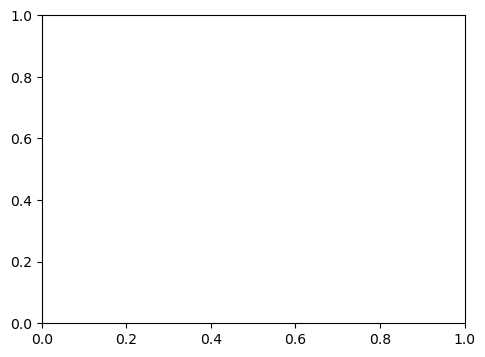

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()